# CS 440/540 Machine Learning in Finance: Homework 2

Download data files from LMS. Code/Explain your solution over this `IPython` notebook at required cells, and complete locally.

To submit your assignment, in LMS, upload your solution to LMS as a single notebook with following file name format:

`lastName_firstName_CourseNumber_HW2.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 440 or CS 540).

Problems on homework assignments are equally weighted.

Any type of plagiarism will not be tolerated. Your submitted codes will be compared with other submissions and also the codes available on internet and violations will have a penalty of -100 points. (In case of copying from
another student both parties will get -100)

Import all libraries here

In [1]:
#Import libraries before starting
import yfinance
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Problem 1: Mean-Variance Portfolio Optimization

In this problem, we will be modifying Mean-Variance portfolio optimization on S&P 500 index constituent stocks between 2015-2017. We will again be training the optimizer between 2015-2016, and testing it on between 2016 and 2017. 

We assume that stocks can only be long, and the whole portfolio should be allocated to stocks (We cannot hold cash). However, we will rebalance the portfolio every Monday in the test period rather than once in a sliding window-based approach.

Run portfolio optimization for a range of lambdas (which is for modeling the relative weight of variance with respect to return): [0.1, 1.0, 5.0, 10.0]. Plot the P&L curve for the testing period. Calculate the Information Ratio based on daily returns for the same testing period. Discuss which lambda value performs the best. Why?

In [2]:
def load_tickers(file_path):
    with open(file_path, 'r') as f:
        tickers = [line.strip() for line in f]
    return tickers

In [3]:
stocks = load_tickers("sp500tickers.txt")

In [4]:
train_start_date = "2015-01-01"
train_end_date = "2016-12-31"
test_start_date = "2016-12-31"
test_end_date = "2017-12-31"

In [5]:
train_data = yfinance.download(stocks, start=train_start_date, end=train_end_date)
test_data = yfinance.download(stocks, start=test_start_date, end=test_end_date)

[*********************100%***********************]  480 of 480 completed
[*********************100%***********************]  480 of 480 completed


In [6]:
train_data_close = train_data['Adj Close']
test_data_close = test_data['Adj Close']

In [7]:
train_data_close

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00+00:00,37.422054,51.079910,24.347168,43.563175,37.108749,18.539352,75.312729,72.339996,45.276859,39.133030,...,127.231194,26.591125,60.042515,47.219227,33.545525,43.244236,101.157707,77.430000,22.049473,40.278931
2015-01-05 00:00:00+00:00,36.720863,51.051487,23.661283,42.743355,37.117008,18.428413,74.041115,71.980003,44.453506,37.778961,...,125.065788,26.289295,58.399662,46.891865,31.457733,42.365597,104.931229,76.339996,21.223301,40.037125
2015-01-06 00:00:00+00:00,36.148819,50.255577,23.663504,42.531799,36.695499,18.469618,73.507057,70.529999,43.410034,37.034210,...,122.397995,26.429165,58.089188,46.309933,31.272747,41.845600,104.041763,75.790001,20.412708,39.646515
2015-01-07 00:00:00+00:00,36.628593,50.227169,23.995314,44.250774,36.993034,18.577387,75.049927,71.110001,43.866547,37.590900,...,125.992577,26.657387,58.677784,47.510189,31.519390,43.232285,106.629333,77.720001,20.607565,40.464928
2015-01-08 00:00:00+00:00,37.726517,50.843048,24.917269,44.713577,37.753395,18.900694,76.194374,72.919998,44.640995,37.041729,...,127.508347,26.966581,59.654446,48.683170,31.757246,43.985397,107.761391,79.379997,20.895950,41.088039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23 00:00:00+00:00,43.425610,46.847839,26.977625,44.215637,33.242958,27.655298,103.794922,105.019997,63.590984,35.913891,...,80.329094,32.142704,62.827381,54.364880,46.308475,55.511860,93.277710,86.419998,34.795685,50.803581
2016-12-27 00:00:00+00:00,43.716995,46.973457,27.148954,44.329113,33.398701,27.480967,103.856796,104.980003,63.995731,36.311607,...,80.238152,32.190117,62.855103,54.208881,46.172310,55.703251,94.025269,87.050003,34.851223,50.746899
2016-12-28 00:00:00+00:00,42.974438,46.065105,27.033195,44.165993,33.069916,27.259092,103.026276,103.769997,63.349857,36.065025,...,79.183357,31.842367,62.543415,53.435146,45.337101,55.433575,94.171463,85.610001,34.335552,50.482399


In [8]:
train_data_close.shape

(504, 480)

In [9]:
train_data_close = train_data_close.fillna(train_data_close.mean()).copy()
test_data_close = test_data_close.fillna(test_data_close.mean()).copy()

In [10]:
train_data_close

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00+00:00,37.422054,51.079910,24.347168,43.563175,37.108749,18.539352,75.312729,72.339996,45.276859,39.133030,...,127.231194,26.591125,60.042515,47.219227,33.545525,43.244236,101.157707,77.430000,22.049473,40.278931
2015-01-05 00:00:00+00:00,36.720863,51.051487,23.661283,42.743355,37.117008,18.428413,74.041115,71.980003,44.453506,37.778961,...,125.065788,26.289295,58.399662,46.891865,31.457733,42.365597,104.931229,76.339996,21.223301,40.037125
2015-01-06 00:00:00+00:00,36.148819,50.255577,23.663504,42.531799,36.695499,18.469618,73.507057,70.529999,43.410034,37.034210,...,122.397995,26.429165,58.089188,46.309933,31.272747,41.845600,104.041763,75.790001,20.412708,39.646515
2015-01-07 00:00:00+00:00,36.628593,50.227169,23.995314,44.250774,36.993034,18.577387,75.049927,71.110001,43.866547,37.590900,...,125.992577,26.657387,58.677784,47.510189,31.519390,43.232285,106.629333,77.720001,20.607565,40.464928
2015-01-08 00:00:00+00:00,37.726517,50.843048,24.917269,44.713577,37.753395,18.900694,76.194374,72.919998,44.640995,37.041729,...,127.508347,26.966581,59.654446,48.683170,31.757246,43.985397,107.761391,79.379997,20.895950,41.088039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23 00:00:00+00:00,43.425610,46.847839,26.977625,44.215637,33.242958,27.655298,103.794922,105.019997,63.590984,35.913891,...,80.329094,32.142704,62.827381,54.364880,46.308475,55.511860,93.277710,86.419998,34.795685,50.803581
2016-12-27 00:00:00+00:00,43.716995,46.973457,27.148954,44.329113,33.398701,27.480967,103.856796,104.980003,63.995731,36.311607,...,80.238152,32.190117,62.855103,54.208881,46.172310,55.703251,94.025269,87.050003,34.851223,50.746899
2016-12-28 00:00:00+00:00,42.974438,46.065105,27.033195,44.165993,33.069916,27.259092,103.026276,103.769997,63.349857,36.065025,...,79.183357,31.842367,62.543415,53.435146,45.337101,55.433575,94.171463,85.610001,34.335552,50.482399


In [11]:
train_returns = train_data_close.pct_change().dropna()
test_returns = test_data_close.pct_change().dropna()

In [12]:
train_returns

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05 00:00:00+00:00,-0.018737,-0.000556,-0.028171,-0.018819,0.000223,-0.005984,-0.016884,-0.004976,-0.018185,-0.034602,...,-0.017019,-0.011351,-0.027361,-0.006933,-0.062238,-0.020318,0.037303,-0.014077,-0.037469,-0.006003
2015-01-06 00:00:00+00:00,-0.015578,-0.015590,0.000094,-0.004949,-0.011356,0.002236,-0.007213,-0.020145,-0.023473,-0.019713,...,-0.021331,0.005320,-0.005316,-0.012410,-0.005880,-0.012274,-0.008477,-0.007205,-0.038194,-0.009756
2015-01-07 00:00:00+00:00,0.013272,-0.000565,0.014022,0.040416,0.008108,0.005835,0.020989,0.008223,0.010516,0.015032,...,0.029368,0.008635,0.010133,0.025918,0.007887,0.033138,0.024870,0.025465,0.009546,0.020643
2015-01-08 00:00:00+00:00,0.029974,0.012262,0.038422,0.010459,0.020554,0.017403,0.015249,0.025453,0.017655,-0.014609,...,0.012031,0.011599,0.016644,0.024689,0.007546,0.017420,0.010617,0.021359,0.013994,0.015399
2015-01-09 00:00:00+00:00,-0.007336,-0.030563,0.001073,-0.027355,-0.010508,-0.008721,-0.001113,-0.014811,-0.000731,-0.008530,...,0.012499,-0.012285,-0.001409,-0.014569,-0.018863,-0.001767,-0.014424,0.014613,-0.027975,0.001585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23 00:00:00+00:00,0.005003,-0.004313,0.001978,0.011028,0.003395,0.001837,-0.002632,0.002865,0.005310,-0.000664,...,0.001020,0.000000,-0.001761,0.001860,-0.002347,-0.003747,0.007384,0.002901,0.002743,0.009764
2016-12-27 00:00:00+00:00,0.006710,0.002681,0.006351,0.002566,0.004685,-0.006304,0.000596,-0.000381,0.006365,0.011074,...,-0.001132,0.001475,0.000441,-0.002869,-0.002940,0.003448,0.008014,0.007290,0.001596,-0.001116
2016-12-28 00:00:00+00:00,-0.016986,-0.019338,-0.004264,-0.003680,-0.009844,-0.008074,-0.007997,-0.011526,-0.010092,-0.006791,...,-0.013146,-0.010803,-0.004959,-0.014273,-0.018089,-0.004841,0.001555,-0.016542,-0.014796,-0.005212


In [13]:
def optimize_portfolio(returns_data, lambda_val):
    avg_returns = returns_data.mean()
    covariance_matrix = cp.psd_wrap(returns_data.cov())  

    weights = cp.Variable(len(avg_returns))
    constraints = [
        cp.sum(weights) == 1,  # fully invested
        weights >= 0           # only long (no short)
    ]

    expected_return = weights @ avg_returns
    risk = cp.quad_form(weights, covariance_matrix)
    objective = cp.Maximize(expected_return - lambda_val * risk)

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return weights.value 

In [14]:
lambda_values = [0.1, 1.0, 5.0, 10.0]
optimized_weights = {}

In [15]:
for lambda_val in lambda_values:
    optimized_weights[lambda_val] = optimize_portfolio(train_returns, lambda_val)

In [16]:
weekly_returns = test_returns.asfreq('W-MON', method='ffill')

In [17]:
pnl_results = {lambda_val: pd.Series(index=weekly_returns.index, dtype='float64') for lambda_val in lambda_values}
info_ratios = []

for lambda_val, weights in optimized_weights.items():
    portfolio_weekly_returns = np.dot(weekly_returns, weights)
    portfolio_volatility = np.std(portfolio_weekly_returns)
    information_ratio = np.mean(portfolio_weekly_returns) / portfolio_volatility
    info_ratios.append({"lambda": lambda_val, "information_ratio": information_ratio})

    cumulative_pnl = np.cumprod(1 + portfolio_weekly_returns)
    for date, pnl_value in zip(weekly_returns.index, cumulative_pnl):
        pnl_results[lambda_val][date] = pnl_value

for res in info_ratios:
    print(f"Lambda: {res['lambda']}, Information Ratio: {res['information_ratio']}")

Lambda: 0.1, Information Ratio: 0.310888634686045
Lambda: 1.0, Information Ratio: 0.3576610503915283
Lambda: 5.0, Information Ratio: 0.3808483294036772
Lambda: 10.0, Information Ratio: 0.3835991462372114


In [18]:
def plot_pnl_curves(pnl_results, lambda_values):
    plt.figure(figsize=(10, 6))
    for lambda_val in lambda_values:
        plt.plot(pnl_results[lambda_val], label=f"Lambda: {lambda_val}")

    plt.title("P&L Curves for Different Lambda Values")
    plt.xlabel("Date")
    plt.ylabel("Cumulative P&L")
    plt.legend(title="Lambda Values")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

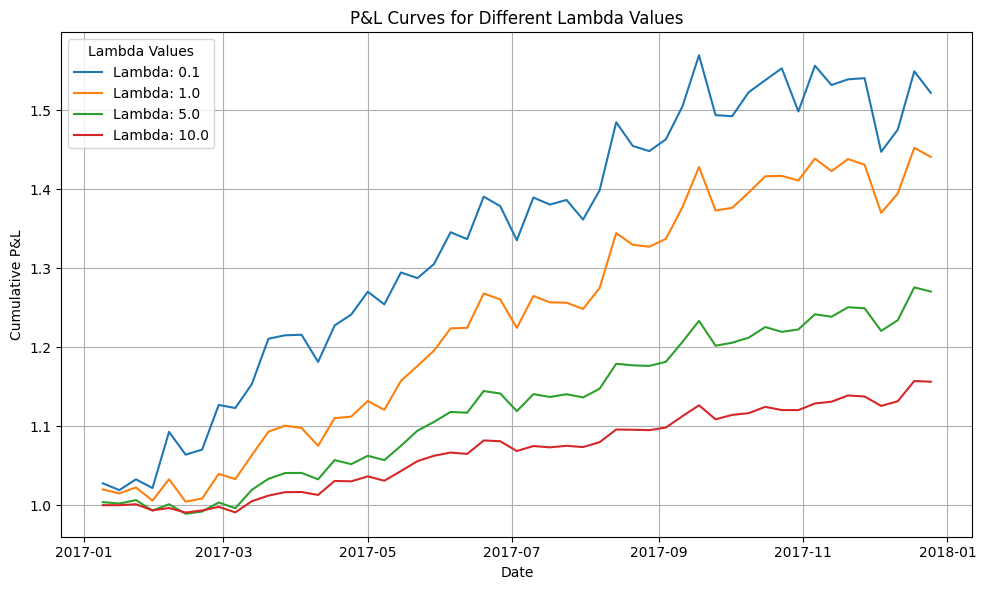

Lambda: 0.1, Information Ratio: 0.310888634686045
Lambda: 1.0, Information Ratio: 0.3576610503915283
Lambda: 5.0, Information Ratio: 0.3808483294036772
Lambda: 10.0, Information Ratio: 0.3835991462372114


In [20]:
plot_pnl_curves(pnl_results, lambda_values)
for res in info_ratios:
    print(f"Lambda: {res['lambda']}, Information Ratio: {res['information_ratio']}")

#### Which lambda value performs best ?
λ = 10 is the best performed value based on information ratio, as it achieves the efficient trade-off between risk and return. (Information ratio high is better so best lambda is the highest value of information ratio given). The Information Ratio measures the risk adjusted return meaning how much return is achieved per unit risk.

## Problem 2: Regularized Linear Regression for Predicting House Price 

Let's focus on the same Real State Price dataset from HW1. In this problem, you are provided a single dataset "kaggle_house.csv" which includes both train and test sets. We will now implement a regularized linear regression by using sklearn to predict house sale price (last column) by using all remaining attributes.

Implement L1 norm and L2 norm regularized linear regression by using sklearn library. Report R2 and RMSE for the test set. To find the optimal regularization hyperparameter lambda, apply 5-fold cross-validation where lambda is in [0.001, 0.01, 0.1, 0.25, 0.5, 1.0]. Our evaluation metric will be Root Mean Squared Error (RMSE). Discuss which regularization method performs better.

In [21]:
data = pd.read_csv('kaggle_house.csv')

In [22]:
features = data.iloc[:, :-1]   # features that are use in prediction
target = data.iloc[:, -1]      # prediction column

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [25]:
X_train.shape, y_train.shape

((1168, 80), (1168,))

In [27]:
X_test.shape, y_test.shape

((292, 80), (292,))

In [28]:
# Separate columns numerical and categorical
categorical_features = [col for col in X_train.columns if X_train[col].dtype == "object"]
numerical_features = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

In [31]:
categorical_features

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [32]:
numerical_features

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [34]:
categorical_na = X_train[categorical_features].isna().sum()
numerical_na = X_train[numerical_features].isna().sum()

categorical_na = categorical_na[categorical_na > 0]
numerical_na = numerical_na[numerical_na > 0]
print(f"Categorical columns with missing values ({len(categorical_na)} columns):")
print(categorical_na)

print(f"\nNumerical columns with missing values ({len(numerical_na)} columns):")
print(numerical_na)

Categorical columns with missing values (16 columns):
Alley           1094
MasVnrType       683
BsmtQual          28
BsmtCond          28
BsmtExposure      28
BsmtFinType1      28
BsmtFinType2      28
Electrical         1
FireplaceQu      547
GarageType        64
GarageFinish      64
GarageQual        64
GarageCond        64
PoolQC          1162
Fence            935
MiscFeature     1122
dtype: int64

Numerical columns with missing values (3 columns):
LotFrontage    217
MasVnrArea       6
GarageYrBlt     64
dtype: int64


In [35]:
from sklearn.impute import SimpleImputer
numeric_transformer = SimpleImputer(strategy='mean')

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('fillna', SimpleImputer(strategy='most_frequent')),  # Missing values filled with most frequent one
    ('encode', OneHotEncoder(handle_unknown='ignore'))    # convert categories into one hot encoded representation
])

In [38]:
from sklearn.compose import ColumnTransformer
data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [39]:
X_train_transformed = data_transformer.fit_transform(X_train)
X_test_transformed = data_transformer.transform(X_test)

In [41]:
X_train_transformed.shape, X_test_transformed.shape

((1168, 286), (292, 286))

In [42]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

regularization_values = [0.001, 0.01, 0.1, 0.25, 0.5, 1.0]

# L1-Regularization (Lasso)
lasso_model = Lasso()
lasso_search = GridSearchCV(
    estimator=lasso_model,
    param_grid={'alpha': regularization_values},
    scoring='neg_root_mean_squared_error',
    cv=5
)
lasso_search.fit(X_train_transformed, y_train)

# L2-Regularization (Ridge)
ridge_model = Ridge()
ridge_search = GridSearchCV(
    estimator=ridge_model,
    param_grid={'alpha': regularization_values},
    scoring='neg_root_mean_squared_error',
    cv=5
)
ridge_search.fit(X_train_transformed, y_train)

/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170760777658.2976, tolerance: 537415025.1745832
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137187716800.137, tolerance: 572016182.2224231
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147506152115.81223, tolerance: 525605188.80204767
  model = cd_fast.sparse_enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0]},
             scoring='neg_root_mean_squared_error')

In [51]:
from sklearn.metrics import r2_score, root_mean_squared_error

# get the best estimators from both lasso and ridge models
optimal_lasso_model = lasso_search.best_estimator_
optimal_ridge_model = ridge_search.best_estimator_

# predict on test dataset with best estimators
lasso_predictions = optimal_lasso_model.predict(X_test_transformed)
ridge_predictions = optimal_ridge_model.predict(X_test_transformed)

# get the rmse and r2 values for the predictions on test set
lasso_rmse = root_mean_squared_error(y_test, lasso_predictions) # squared version was depreceated and new RMSE calculation done with this function from sklearn
lasso_r2 = r2_score(y_test, lasso_predictions)

# calculate
ridge_rmse = root_mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Lasso Regression: RMSE = {lasso_rmse:.4f}, R2 = {lasso_r2:.4f}")
print(f"Ridge Regression: RMSE = {ridge_rmse:.4f}, R2 = {ridge_r2:.4f}")


Lasso Regression: RMSE = 28239.2015, R2 = 0.8960
Ridge Regression: RMSE = 34613.3647, R2 = 0.8438


- Lasso regression has lower RMSE compared to Ridge Regression (2829.2015 / 34613.3647). This means that Lasso predictions closer to the actual values of house prices in average. 

- Lasso regression achieves a higher value of R^2 (0.896 > 0.8438). R^2 measures model wellness explanation of variance in the target variable. Higher R^2 shows that Lasso Regression explains better variability in the house price data compared to Ridge Regression.

- As a result, Lasso Regression outperforms Ridge Regression in the house prediction dataset as it achives both lower RMSE and higher R^2.

## Problem 3: Logistic Regression for Inferring Home Ownership Type on Lending Data

In this problem, we will focus on determining the home ownership type(mortgage, rent, etc) in "lending_data" by using L1 regularized logistic regression. You can use sklearn. To find the optimal regularization hyperparameter lambda, we will apply 5-fold cross-validation where lambda can be [0.001, 0.01, 0.1, 0.25, 0.5, 1.0]. Our evaluation metric will be F1 score. Discuss which regularization method performs better.

In [2]:
data = pd.read_excel("lending_data.xlsx")

In [3]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0


In [4]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies'],
      dtype='object')

In [5]:
# for each column, count na values
missing_values = data.isna().sum()

columns_with_na = missing_values[missing_values > 0]

print(f"Columns with missing values ({len(columns_with_na)}):")
print(columns_with_na)

Columns with missing values (6):
emp_title               22927
emp_length              18301
title                    1756
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64


In [6]:
# drop na values that are not much for the specific columns
data = data.dropna(subset=['title','revol_util','pub_rec_bankruptcies'])

In [7]:
from sklearn.impute import SimpleImputer

categorical_columns = ['emp_title', 'emp_length']
categorical_imputer = SimpleImputer(strategy='most_frequent')
# Impute with most frequent values for the categorical columns
data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

In [8]:
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Impute missing values with mean for numerical column
data['mort_acc'] = numerical_imputer.fit_transform(data[['mort_acc']])

In [9]:
na_counts_after_imputation = data.isna().sum()

columns_with_na_after_imputation = na_counts_after_imputation[na_counts_after_imputation > 0]

print(f"Columns with missing values after imputation ({len(columns_with_na_after_imputation)}):")
print(columns_with_na_after_imputation)

if len(columns_with_na_after_imputation) == 0:
    print("No missing values remain in the dataset.")

Columns with missing values after imputation (0):
Series([], dtype: int64)
No missing values remain in the dataset.


In [10]:
features = data.drop(columns=['home_ownership'])
target = data['home_ownership']

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

categorical_features = features.select_dtypes(exclude=["number"]).columns
numerical_features = features.select_dtypes(include=["number"]).columns
features[categorical_features] = features[categorical_features].astype(str) # without this, I am getting type error in grid search

label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.2, random_state=42)

In [13]:
X_train.shape, y_train.shape

((314771, 25), (314771,))

In [14]:
X_test.shape, y_test.shape

((78693, 25), (78693,))

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [16]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies'],
      dtype='object')

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
log_reg_pipeline = Pipeline(steps=[
    ('data_transform', data_transformer),  # preprocess data
    ('logistic_model', log_reg_model)     # logistic regression model
])


In [19]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

lambda_values = [0.001, 0.01, 0.1, 0.25, 0.5, 1.0]
regularization_strengths = [1 / lamb for lamb in lambda_values]
hyperparameter_grid = {'logistic_model__C': regularization_strengths} # sckit learn uses 1/lambda as C value instead of lambda

weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# Grid Search with pipeline and lambda values as 5 fold cross validation
grid_search_pipeline = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=hyperparameter_grid,
    cv=5,
    scoring=weighted_f1_scorer,
    verbose=1
)
# fit the grid search
grid_search_pipeline.fit(X_train, y_train)

# best lambda finding
best_C = grid_search_pipeline.best_params_['logistic_model__C']
best_lambda = 1 / best_C
best_f1_score = grid_search_pipeline.best_score_

print(f"Optimal Lambda: {best_lambda:.4f}")
print(f"Best F1 Score: {best_f1_score:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Optimal Lambda: 1.0000
Best F1 Score: 0.6761


In [22]:
target_prediction = grid_search_pipeline.predict(X_test) # prediction on test set

In [25]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, target_prediction)
print(f"Accuracy valuen on test dataset: {accuracy}")

f1_score_value = f1_score(y_test, target_prediction, average="weighted")
print(f"f1 score on test dataset: {f1_score_value}")

Accuracy valuen on test dataset: 0.7114609939893002
f1 score on test dataset: 0.6768995381956876


In [26]:
results = pd.DataFrame(grid_search_pipeline.cv_results_)
results['lambda'] = 1 / results['param_logistic_model__C']
print(results[['lambda', 'mean_test_score']])

   lambda  mean_test_score
0   0.001         0.642559
1   0.010         0.628597
2   0.100         0.657186
3   0.250         0.666676
4   0.500         0.674706
5   1.000         0.676149


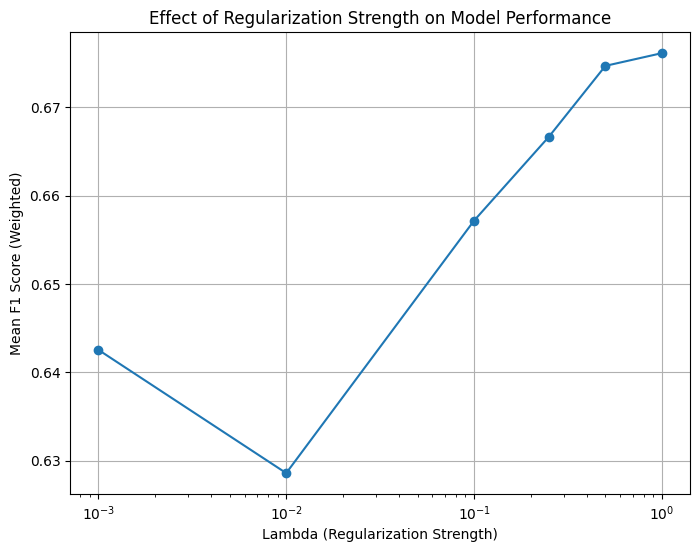

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(results['lambda'], results['mean_test_score'], marker='o')
plt.xscale('log') 
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Mean F1 Score (Weighted)')
plt.title('Effect of Regularization Strength on Model Performance')
plt.grid(True)
plt.show()

Lambda value as 1 gives the best performance over test dataset. On test dataset, comparison of mean test scores shows that lambda value 1 outperforms other lambda values in L1 regularized logistic regression.

## Problem 4: Fitting Optimal ARIMA Model to Turkish Unemployment Rate Data

In this problem, you will focus on fitting ARIMA type model to Turkish monthly unemployment rate data. The data is obtained from Central Bank, and provided to you in "unemployment.xlsx".

You do not need to implement ARIMA from scratch. You can use the existing implementation in statsmodels. What is the optimal integration order for ARIMA? 0, 1 or 2? 

In [28]:
from statsmodels.tsa.arima.model import ARIMA

In [29]:
data = pd.read_excel("unemployment.xlsx")

In [30]:
data.columns

Index(['Tarih', 'TP YISGUCU2 G8'], dtype='object')

In [31]:
data.shape

(173, 2)

In [32]:
data.head()

,Tarih,TP YISGUCU2 G8
0,2014-01,10.5
1,2014-02,10.5
2,2014-03,9.4
3,2014-04,8.8
4,2014-05,8.4


In [33]:
data.isna().sum()

Tarih             39
TP YISGUCU2 G8    57
dtype: int64

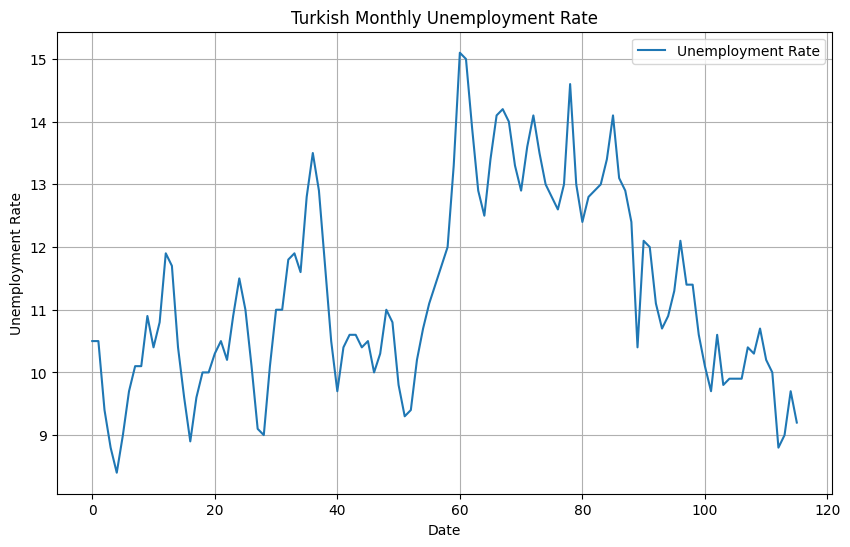

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(data['TP YISGUCU2 G8'], label='Unemployment Rate')
plt.title('Turkish Monthly Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
data.dropna(inplace=True)

In [35]:
data.isna().sum()

Tarih             0
TP YISGUCU2 G8    0
dtype: int64

In [39]:
from statsmodels.tsa.stattools import adfuller

# test the stationarity
result = adfuller(data['TP YISGUCU2 G8'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.755171163476487
p-value: 0.40293392955398055


In [40]:
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Differencing is needed.")

The time series is not stationary. Differencing is needed.


In [41]:
data_diff1 = data['TP YISGUCU2 G8'].diff().dropna()

In [42]:
result_diff1 = adfuller(data_diff1)
print(f"First Differencing - ADF Statistic: {result_diff1[0]}")
print(f"First Differencing - p-value: {result_diff1[1]}")

First Differencing - ADF Statistic: -2.422942487916959
First Differencing - p-value: 0.13536547968255502


In [43]:
data_diff2 = data_diff1.diff().dropna()

In [44]:
result_diff2 = adfuller(data_diff2)
print(f"Second Differencing - ADF Statistic: {result_diff2[0]}")
print(f"Second Differencing - p-value: {result_diff2[1]}")

Second Differencing - ADF Statistic: -9.053425033695191
Second Differencing - p-value: 4.771706312993655e-15


In [47]:
arima_model_1 = ARIMA(data['TP YISGUCU2 G8'], order=(1, 1, 1))
results_arima_model_1 = arima_model_1.fit()
print(results_arima_model_1.summary())

                               SARIMAX Results                                
Dep. Variable:         TP YISGUCU2 G8   No. Observations:                  116
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -119.981
Date:                Sun, 01 Dec 2024   AIC                            245.963
Time:                        19:16:48   BIC                            254.197
Sample:                             0   HQIC                           249.305
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3069      0.351     -0.874      0.382      -0.995       0.381
ma.L1          0.5362      0.339      1.580      0.114      -0.129       1.201
sigma2         0.4714      0.065      7.234      0.0

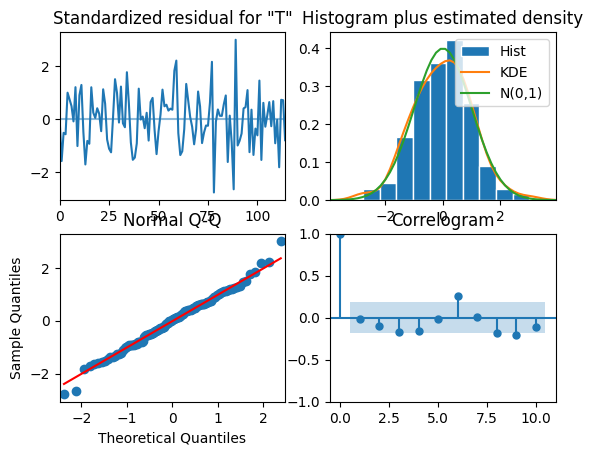

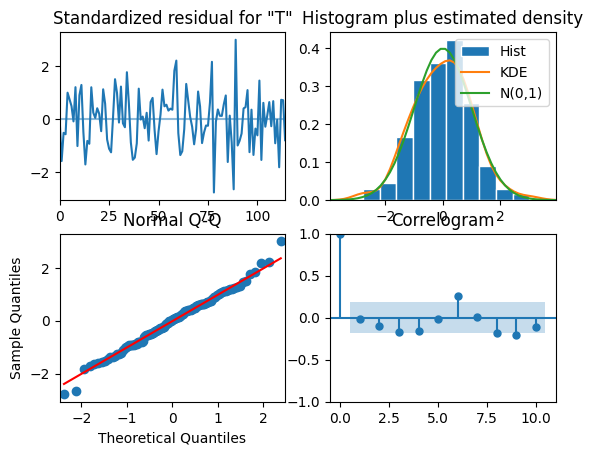

In [50]:
results_arima_model_1.plot_diagnostics()

In [48]:
arima_model_2 = ARIMA(data['TP YISGUCU2 G8'], order=(1, 2, 1))
results_arima_model_2 = arima_model_2.fit()
print(results_arima_model_2.summary())

                               SARIMAX Results                                
Dep. Variable:         TP YISGUCU2 G8   No. Observations:                  116
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -123.187
Date:                Sun, 01 Dec 2024   AIC                            252.375
Time:                        19:18:17   BIC                            260.583
Sample:                             0   HQIC                           255.706
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1771      0.089      1.985      0.047       0.002       0.352
ma.L1         -0.9996      2.897     -0.345      0.730      -6.678       4.678
sigma2         0.4892      1.401      0.349      0.7

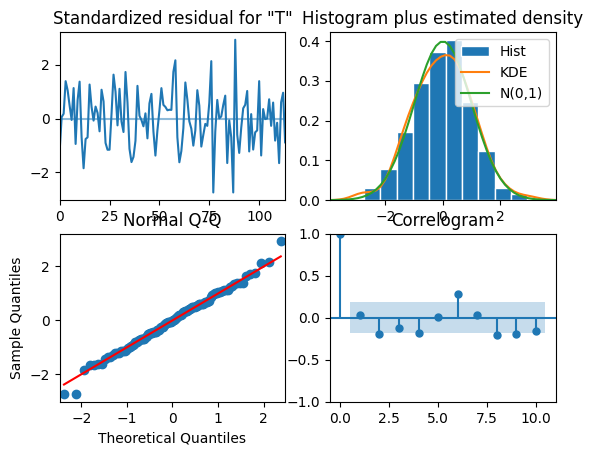

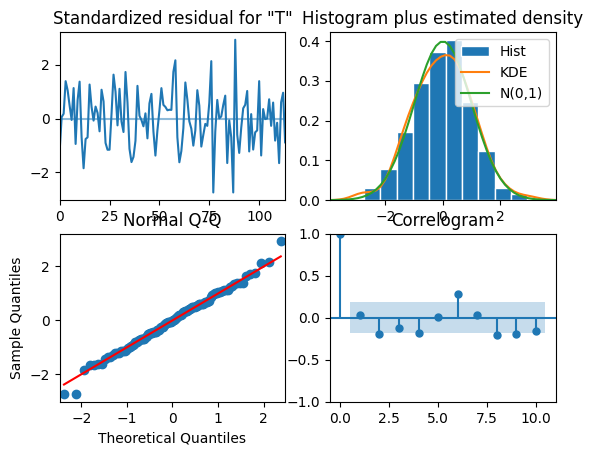

In [51]:
results_arima_model_2.plot_diagnostics()

In [49]:
arima_model_3 = ARIMA(data['TP YISGUCU2 G8'], order=(1, 3, 1))
results_arima_model_3 = arima_model_3.fit()
print(results_arima_model_3.summary())

                               SARIMAX Results                                
Dep. Variable:         TP YISGUCU2 G8   No. Observations:                  116
Model:                 ARIMA(1, 3, 1)   Log Likelihood                -148.646
Date:                Sun, 01 Dec 2024   AIC                            303.292
Time:                        19:18:59   BIC                            311.475
Sample:                             0   HQIC                           306.613
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2773      0.103     -2.687      0.007      -0.480      -0.075
ma.L1         -0.9996      6.475     -0.154      0.877     -13.691      11.692
sigma2         0.7759      5.029      0.154      0.8

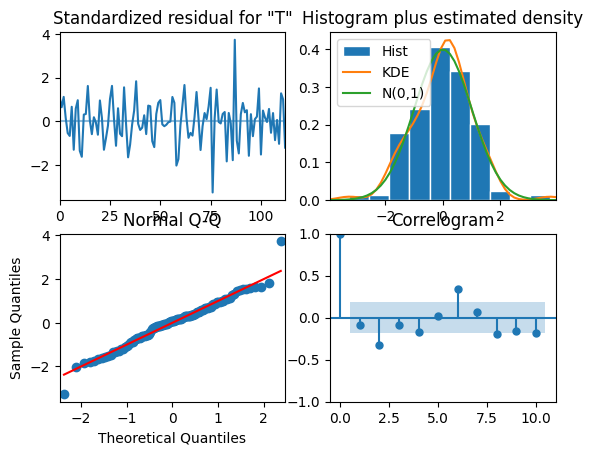

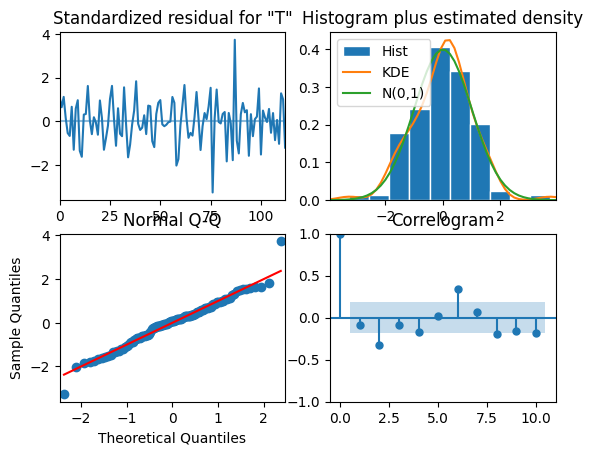

In [52]:
results_arima_model_3.plot_diagnostics()